# Assignment 1

**Deadline**:  17/09/2024, 17.00

**Names and student numbers:**
1. name (student number)
2. ...
3. ...

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignments group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

## Part 0: importing the relevant libraries

**Exercise 1:** import all the libraries you are using in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd

## Part 4: comparing different regression methods

The aim of this part of the assignment is to compare three regression estimators: polynomial regression, K-nearest neighbor regression and kernel regression. In order to control the underlying regression function, and to make sure that it is nonlinear, we use simulated data. The target variable $y = f(x)$ is a nonlinear function of the 1-dimensional feature $x$. In the cell below, the simulated data is imported and plotted.

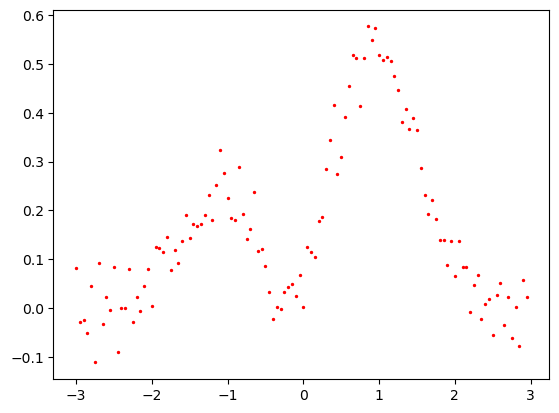

In [2]:
data = np.loadtxt("DSM_assignment1_regression_data.csv")
x = data[:,0]
y = data[:,1]

plt.scatter(x, y, s=2, c='red');

**Exercise 9:** use $10$-fold cross-validation to estimate the root-mean-square error (RMSE) of a K-nearest neighbor regression model with uniform weights and with varying number of nearest neighbors taken into account. In other words, use the cell below to make a plot of the CV-estimated RMSE (**including** errorbars signifying one standard deviation) as a function of $K$. Choose the range of $K$ such that the bias-variance tradeoff is clearly visible in the plot.

Finally, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of $K$ based on your analysis.

You may use existing packages to perform the K-nearest neighbors regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.

Number of neighbors (k) minimizing RMSE: 8
Optimal number of neighbors (k) using the one standard error rule: 6


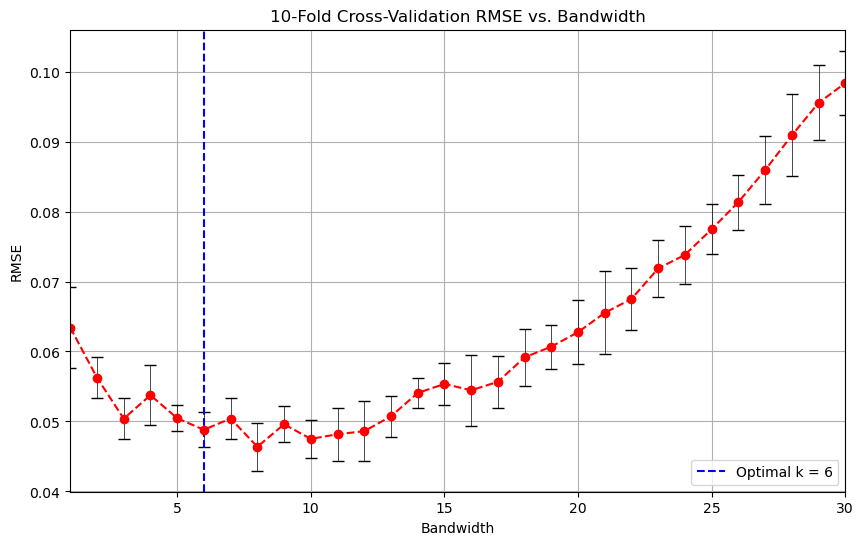

In [3]:
# Firstly, we need to define the k-NN regression function - we used the same function as in the computer class.

def kNN_reg(x, y, k):
    
    def kNN_predict(X_new):
        
        distances = np.abs(X_new.reshape(-1,1) - x)    # distances
        idx = np.argpartition(distances, k-1, axis=1)[:, :k]  # indices of nearest neighbors
              
        return np.mean(y[idx], axis=1)
    
    return kNN_predict

# Now, we need to define the function that will generate the indices for the k-fold cross-validation. Function was also used from computer class.
def generate_CV_test_indices(N, K):
    
    ints = np.random.permutation(np.arange(N))
        
    short_length = N // K
    number_long_folds = N % K
    
    long_folds = ints[:number_long_folds*(short_length + 1)].reshape(number_long_folds, short_length + 1)
    short_folds = ints[number_long_folds*(short_length + 1):].reshape(K - number_long_folds, short_length)
    
    return list(long_folds) + list(short_folds)

# Now, we need to define the function that will calculate the RMSE for the k-NN regression model.
def CV_RMSE_knn(x, y, K, nn): # nn as number of neighbors, K as number of folds
    N = len(y)
    CVk = np.array([])

    for test_indices in generate_CV_test_indices(N, K):
        x_train, x_test = np.delete(x, test_indices), x[test_indices] # we use analogous approach as was used for RMSE of polynomial regression in computer class
        y_train, y_test = np.delete(y, test_indices), y[test_indices]

        # Train the k-NN model
        predictor = kNN_reg(x_train, y_train, nn)

        # Predict on test set
        y_pred = predictor(x_test)

        # Calculate RMSE for this fold
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        CVk = np.append(CVk, rmse)

    # Return mean RMSE and standard deviation (std)
    return np.mean(CVk), np.std(CVk, ddof=1) / np.sqrt(K)

# 10-fold Cross-Validation parameters
K = 10
K_nn = range(1, 31)  # Values of number of neighbors to test

# Perform and store the CV results for each k
CV_results = []
for k_val in K_nn:
    mean_rmse, std_err = CV_RMSE_knn(x, y, K, k_val)
    CV_results.append([mean_rmse, std_err])

CV_results = np.array(CV_results)
RMSEs = CV_results[:, 0]
standard_errors = CV_results[:, 1]

# Find the minimum RMSE and its corresponding number of neighbors
min_rmse_index = np.argmin(RMSEs)
min_rmse = RMSEs[min_rmse_index]
one_sd_above_min = min_rmse + standard_errors[min_rmse_index]
min_neighbor = K_nn[min_rmse_index]

# Save the minimum RMSE and its standard error for Ex13
nn_min_rmse = RMSEs[min_rmse_index]
nn_min_rmse_std_err = standard_errors[min_rmse_index]

# Find the smallest k within one standard deviation of the minimum RMSE
optimal_k = None
for i in range(len(RMSEs)):
    if RMSEs[i] <= one_sd_above_min:
        optimal_k = K_nn[i]
        break

# Display the optimal k
print(f"Number of neighbors (k) minimizing RMSE: {min_neighbor}")
print(f"Optimal number of neighbors (k) using the one standard error rule: {optimal_k}")

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(K_nn, RMSEs, yerr=standard_errors, capsize=4, fmt='ro--', ecolor='black', elinewidth=0.5)

ax.set_xlim(left=1, right=max(K_nn))
ax.set_xlabel('Bandwidth')
ax.set_title('10-Fold Cross-Validation RMSE vs. Bandwidth')
ax.grid(True)
ax.set_ylabel('RMSE')

# Draw a vertical line at the optimal k value
ax.axvline(x=optimal_k, color='blue', linestyle='--', label=f'Optimal k = {optimal_k}')
ax.legend()

plt.show()

#### ANSWER IN PLAIN TEXT: ####
Based on our analysis we see that RMSE is minimized with respect to k when k is equal to `{{min_neighbor}}`. We then apply the "one standard deviation rule of thumb" which says that we should take the smallest k which has RMSE at most one standard deviation away from the minimum. That is true for k=`{{optimal_k}}`, therefore, our analysis suggests we should use a model with `{{optimal_k}}`-nearest neighbors.


**Exercise 10:** repeat the previous exercise, but now for kernel regression with a Gaussian kernel. Plot the RMSE as a function of the bandwidth, instead of the number of nearest neighbors taken into account. Again, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of the bandwidth based on your analysis.

You may use existing packages to perform the kernel regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.

Minimum RMSE bandwidth: 0.1553
Optimal bandwidth using the one standard error rule: 0.0952


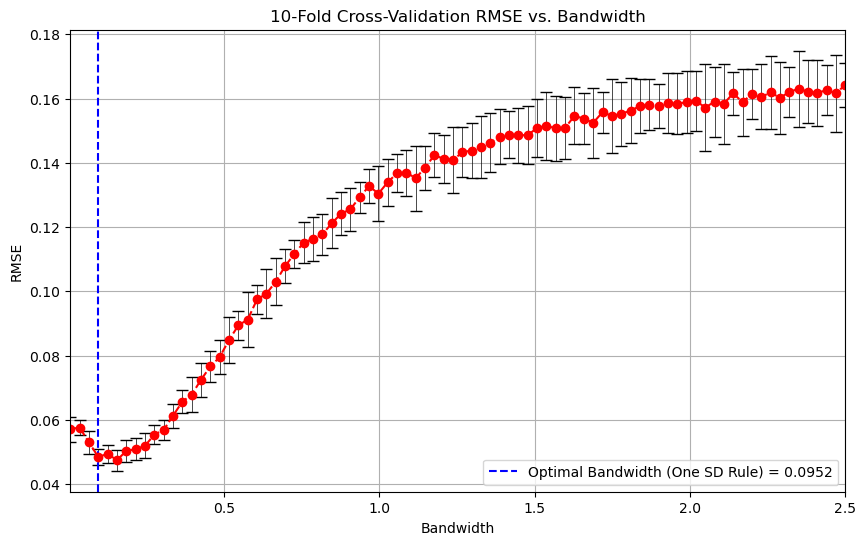

In [4]:
# Firstly, we need to define the kernel regression function - we used the same function as in the computer class.

def kern_reg(x, y, bw = 0.1):
    
    def predictor(X_new):
        
        differences = X_new.reshape(-1,1) - x
        Kh = stats.norm.pdf(differences, loc=0, scale=bw)  # Gaussian kernel

        weights = (Kh.T / np.sum(Kh, axis=1)).T 
        
        return weights @ y
    
    return predictor

# Now, we need to define the function that will calculate the RMSE for the kernel regression model.
def CV_RMSE_kernel(x, y, K, bandwidth):
    N = len(y)
    CVk = np.array([])

    for test_indices in generate_CV_test_indices(N, K):
        x_train, x_test = np.delete(x, test_indices), x[test_indices]
        y_train, y_test = np.delete(y, test_indices), y[test_indices]

        # Train the kernel regression model
        predictor = kern_reg(x_train, y_train, bw=bandwidth)

        # Predict on test set
        y_pred = predictor(x_test)

        # Calculate RMSE for this fold
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        CVk = np.append(CVk, rmse)

    # Return mean RMSE and standard deviation (std)
    return np.mean(CVk), np.std(CVk, ddof=1) / np.sqrt(K)

# Calculate standard deviation of x
std_x = np.std(x)

# Define the range of bandwidths to test
bw_values = np.linspace(0.005, 2.5, 84)
hrange = np.linspace(0.005, 2.5, 21) # For the plot we want every 4th value shown

# Store the CV results for each bandwidth
CV_results = []
for bw in bw_values:
    mean_rmse, std_err = CV_RMSE_kernel(x, y, K, bw)
    CV_results.append([mean_rmse, std_err])

CV_results = np.array(CV_results)
RMSEs = CV_results[:, 0]
standard_errors = CV_results[:, 1]

# Find the minimum RMSE and its corresponding bandwidth
min_rmse_index = np.argmin(RMSEs)
min_rmse = RMSEs[min_rmse_index]
min_bandwidth = bw_values[min_rmse_index]

# Save the minimum RMSE and its standard error for Ex13
kernel_min_rmse = RMSEs[min_rmse_index]
kernel_min_rmse_std_err = standard_errors[min_rmse_index]

# Find the smallest bandwidth within one standard deviation of the minimum RMSE
one_sd_above_min = min_rmse + standard_errors[min_rmse_index]

optimal_bandwidth = None
for i in range(len(RMSEs)):
    if RMSEs[i] <= one_sd_above_min:
        optimal_bandwidth = bw_values[i]
        break

# Display results
print(f"Minimum RMSE bandwidth: {min_bandwidth:.4f}")
print(f"Optimal bandwidth using the one standard error rule: {optimal_bandwidth:.4f}")

# Plotting the results and the optimal bandwidth
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(bw_values, RMSEs, yerr=standard_errors, capsize=4, fmt='ro--', ecolor='black', elinewidth=0.5)

ax.set_xlim(left=min(bw_values), right=max(bw_values))
ax.set_xlabel('Bandwidth')
ax.set_title('10-Fold Cross-Validation RMSE vs. Bandwidth')
ax.grid(True)
ax.set_ylabel('RMSE')

# Mark the optimal bandwidth on the plot
ax.axvline(x=optimal_bandwidth, color='blue', linestyle='--', label=f'Optimal Bandwidth (One SD Rule) = {optimal_bandwidth:.4f}')
ax.legend()

plt.show()



#### ANSWER IN PLAIN TEXT: ####
We used analogous approach as in previous part. We minimized RMSE function with respect to bandwidth value and found out that bandwidth minimizing the RMSE function is equal to `{{min_bandwidth}}` and using the one standard deviation rule we found our optimal bandwidth equal to `{{optimal_bandwidth}}`.


**Exercise 11:** repeat the analysis of the two previous exercises, but now for polynomial regression. Plot the RMSE as a function of the degree of the polynomial, instead of the number of nearest neighbors taken into account or the bandwidth. Again, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of the degree of the polynomial based on your analysis.

You may use existing packages to perform the polynomial regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.

M minimizing RMSE: 17
Optimal M using the one standard error rule: 10


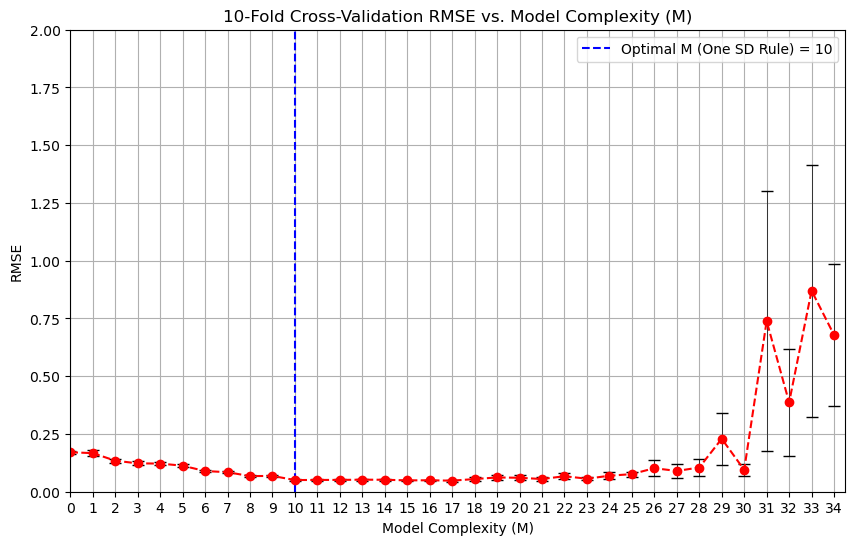

In [5]:
# Firstly, we need to define the polynomial regression function - we used the same function as in the computer class.

def polynomial_features(X, M, bias=True):
    if bias:
        return np.concatenate(tuple([X**n for n in range(M+1)]), axis=1)
    if not bias:
        return np.concatenate(tuple([X**n for n in range(1, M+1)]), axis=1)

# A function to calculate the parameters of the linear model
def get_parameters_lin_mod(X, y):
    return np.linalg.pinv(X) @ y

# A function to train the linear model
def train_lin_mod(X, y):
    
    parameters = get_parameters_lin_mod(X, y)
    
    def fhat(X_new): return X_new @ parameters
    
    return fhat    

# Now, we need to define the function that will calculate the RMSE for the polynomial regression model.
def CV_RMSE(X, y, M, K):
    
    N = len(y)    
    X_derived = polynomial_features(X, M)   
    CVk = np.array([])    
                           
    
    for test_indices in generate_CV_test_indices(N, K):
        
        X_training, X_test = np.delete(X_derived, test_indices, axis=0), X_derived[test_indices]
        y_training, y_test = np.delete(y, test_indices), y[test_indices]
        
        model = train_lin_mod(X_training, y_training)
    
        CVk = np.append(CVk, np.sqrt(np.mean((y_test - model(X_test))**2)))
        
    return np.mean(CVk), np.std(CVk, ddof=1)/np.sqrt(K)

# All these functions above were used in the computer class.

# 10-fold Cross-Validation parameters
Mmin = 0
Mmax = 34
Mrange = range(Mmin, Mmax + 1)

X = x.reshape(-1,1)

# Perform and store the CV results for each M
CV_results = []
for M in Mrange: CV_results.append(list(CV_RMSE(X, y, M, K)))

CV_results = np.array(CV_results)
RMSEs = CV_results[:,0]
standard_errors = CV_results[:,1]

# Find the minimum RMSE and its standard deviation
min_rmse_index = np.argmin(RMSEs)
min_rmse = RMSEs[min_rmse_index]
one_sd_above_min = min_rmse + standard_errors[min_rmse_index]

# Save the minimum RMSE and its standard error for Ex13
poly_min_rmse = RMSEs[min_rmse_index]
poly_min_rmse_std_err = standard_errors[min_rmse_index]

# Find the smallest M within one standard deviation of the minimum RMSE
optimal_M = None
for M in range(len(RMSEs)):
    if RMSEs[M] <= one_sd_above_min:
        optimal_M = M
        break
min_M = range(len(RMSEs))[min_rmse_index]

# Display the "optimal" M
print(f"M minimizing RMSE: {min_M}")
print(f"Optimal M using the one standard error rule: {optimal_M}")


# Plotting the results with the optimal M indicated
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(Mrange, RMSEs, yerr=standard_errors, capsize=4, fmt='ro--', ecolor='black', elinewidth=0.5)

ax.set_xlim(left=0.5, right=Mmax+0.5)
ax.set_xticks(Mrange)
ax.set_xlabel('Model Complexity (M)')
ax.set_title('10-Fold Cross-Validation RMSE vs. Model Complexity (M)')
ax.grid(True)
ax.set_ylim(bottom=0, top=2)
ax.set_ylabel('RMSE')

# Mark the optimal M on the plot
ax.axvline(x=optimal_M, color='blue', linestyle='--', label=f'Optimal M (One SD Rule) = {optimal_M}')
ax.legend()

plt.show()


#### ANSWER IN PLAIN TEXT: ####

Again, we did used analogous analysis just minimized RMSE function with respect to M. We can see that M minimizing RMSE function is equal to `{{min_M}}` and using the one standard deviation rule we found our optimal bandwidth equal to `{{optimal_M}}`.

**Exercise 12:** create a single plot that includes the original data and the optimal predictions according to the three methods of regression applied in the previous three exercises. Use a legend to make clear which prediction is associated with which method.

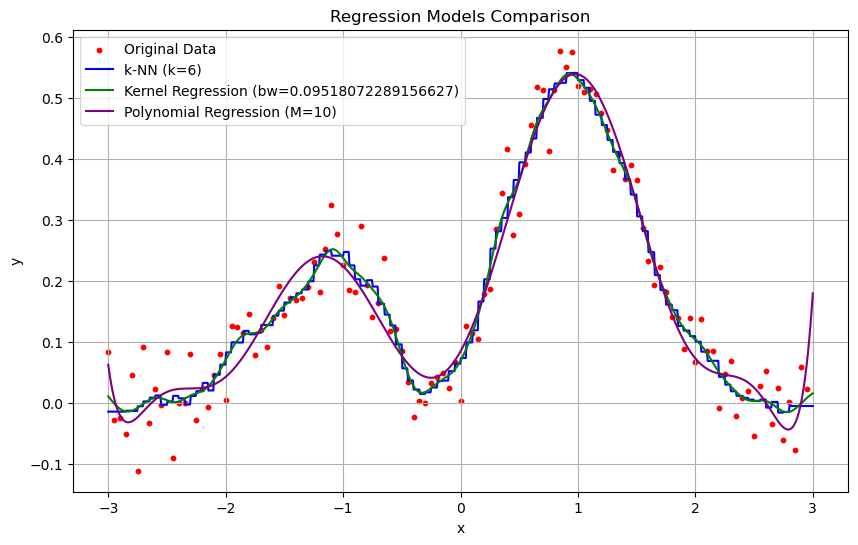

In [6]:
# Saved results
optimal_k  
optimal_bw = optimal_bandwidth  
optimal_M

# Prepare predictions
T = np.linspace(-3, 3, 1000).reshape(-1, 1)  # Generate test points

# k-NN Regression prediction
knn_predictor = kNN_reg(x, y, optimal_k)
y_knn = knn_predictor(T)

# Kernel Regression prediction
kernel_predictor = kern_reg(x, y, bw=optimal_bw)
y_kernel = kernel_predictor(T)

# Polynomial Regression prediction
X_poly = polynomial_features(x.reshape(-1, 1), optimal_M)
model_poly = train_lin_mod(X_poly, y)
X_new_poly = polynomial_features(T, optimal_M)
y_poly = model_poly(X_new_poly)

# Plotting the original data and the three models
fig, ax = plt.subplots(figsize=(10, 6))

# Original data
ax.scatter(x, y, s=10, c='red', label='Original Data')

# k-NN regression
ax.plot(T, y_knn, label=f'k-NN (k={optimal_k})', color='blue')

# Kernel regression
ax.plot(T, y_kernel, label=f'Kernel Regression (bw={optimal_bw})', color='green')

# Polynomial regression
ax.plot(T, y_poly, label=f'Polynomial Regression (M={optimal_M})', color='purple')

# Enhancing the plot
ax.set_title('Regression Models Comparison')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True)

plt.show()


**Exercise 13:** the DataFrame `df` that is uploaded in the cell below contains 9 missing values. Use your analysis of the previous exercises to complete the DataFrame by filling in and/or computing the missing values.

Finally, use the markdown cell at the bottom of the notebook to explain (in your own words) whether or not, based on your analysis, any of the models is preferable over the others.

In [7]:
df = pd.read_pickle("DSM_assignment1_dataframe_empty.csv")
df['optimal value of hyperparameter'] = [optimal_k, optimal_bw, optimal_M]
df['optimal RMSE (10-fold CV estimate)'] = [nn_min_rmse, kernel_min_rmse, poly_min_rmse]
df['standard deviation of RMSE estimate'] = [nn_min_rmse_std_err, kernel_min_rmse_std_err, poly_min_rmse_std_err]
df

,type of hyperparameter,optimal value of hyperparameter,optimal RMSE (10-fold CV estimate),standard deviation of RMSE estimate
K-nearest neighbors,K,6.000000,0.046384,0.003423
kernel regression,bandwidth,0.095181,0.047432,0.003284
polynomial regression,degree of polynomial,10.000000,0.047893,0.004322


#### ANSWER IN PLAIN TEXT: ####
Based on our analysis we can see that the results from all three methods are very similar, at least from the point of view of RMSE and its standard deviation. Moreover, when we run the code multiple times we can see that the order of which method has the least optimal RMSE or standard deviation of RMSE changes.